# AI Urban Warfare Analyst - Stage 2: Frame Analysis & Annotation

This notebook demonstrates **Stage 2** of the Urban Warfare Analyst pipeline:

1. **Load extracted frames** from Stage 1
2. **Analyze frames** using Gemini 2.5 Flash for tactical analysis
3. **Parse structured JSON** with soldier positions, threats, errors, strengths
4. **Generate annotated frames** with tactical overlays
5. **Save outputs** to separate folders (JSON + images)

**Target Runtime:** ~30 seconds per frame

---

## Cell 1: Environment Setup and Imports

**Expected Runtime:** ~5 seconds

In [1]:
# Install dependencies if needed (uncomment for Google Colab)
# !pip install -q google-generativeai Pillow opencv-python python-dotenv

import sys
import json
from pathlib import Path
from IPython.display import Image as IPImage, display
import ipywidgets as widgets

# Import our custom modules
from config import Config, config
from frame_extractor import FrameExtractor
from frame_analyzer import FrameAnalyzer

# Initialize configuration
print("🚀 AI URBAN WARFARE ANALYST - STAGE 2")
print("=" * 60)
config.print_config()
print()

# Initialize analyzers
extractor = FrameExtractor(config)
analyzer = FrameAnalyzer(config)

print("✅ Frame extractor initialized")
print("✅ Frame analyzer initialized")
print(f"📊 Analysis Model: {config.GEMINI_ANALYSIS_MODEL}")
print(f"🎨 Image Model: {config.GEMINI_IMAGE_MODEL}")
print(f"💾 JSON Output: {config.ANALYSIS_JSON_DIR}")
print(f"🖼️  Frame Output: {config.ANNOTATED_FRAMES_DIR}")
print("\n" + "=" * 60)

🚀 AI URBAN WARFARE ANALYST - STAGE 2
AI URBAN WARFARE ANALYST - CONFIGURATION
API Key Set: ✅

Models:
  Stage 2 (Analysis): gemini-2.5-flash-preview-09-2025
  Stage 3 (Overlays): gemini-3-pro-image-preview
  Default/Fallback: gemini-2.5-flash-preview-09-2025

Model Parameters:
  Temperature: 0.7
  Max Tokens: 2048

Frame Extraction:
  Number of Frames: 3
  Extraction Positions: ['25%', '50%', '75%']
  Max Frame Size: 720px
  Frame Format: JPEG (Quality: 85)

Video Limits:
  Max Duration: 120s
  Max File Size: 100MB
  Supported Formats: .mp4, .mov, .avi, .mkv, .wmv

Directories:
  Base: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst
  Output: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst/outputs
  Prompts: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst/prompts

✅ Frame extractor initialized
✅ Frame analyzer initialized
📊 Analysis Model: gemini-2.5

## Cell 2: Load Frames from Stage 1

**Expected Runtime:** ~5 seconds

Load the frames extracted in Stage 1 or extract new ones

In [2]:
# 📝 EDIT THIS PATH TO YOUR VIDEO FILE
video_path = "./Training Footage/urban_warfare_training.mp4"

# Optional: Scenario context for analysis
scenario_context = """
Urban warfare training exercise:
- 4-person fire team
- Building clearing operation
- Multiple threats (windows, doorways, corners)
- Objective: Clear and secure structure
"""

print("🎬 Loading frames from video...")
print(f"📁 Video path: {video_path}\n")

# Validate video
validation_result = extractor.validate_video(video_path)

if not validation_result['valid']:
    print(f"❌ Video validation failed: {validation_result['error']}")
    raise ValueError("Video validation failed")

video_metadata = validation_result['metadata']
video_name = Path(video_path).stem

print("✅ Video validated")
print(f"  📁 File: {video_metadata['filename']}")
print(f"  ⏱️  Duration: {video_metadata['duration']:.1f}s")
print(f"  🎥 Resolution: {video_metadata['resolution'][0]}x{video_metadata['resolution'][1]}")
print()

# Extract key frames
print("🎬 Extracting key frames...")
frames = extractor.extract_key_frames(
    video_path=video_path,
    num_frames=config.NUM_FRAMES,
    positions=config.FRAME_EXTRACTION_POSITIONS,
    resize_max=config.FRAME_RESIZE_MAX
)

print(f"\n✅ Extracted {len(frames)} frames")
print(f"  ⏱️  Timestamps: {[f'{t:.1f}s' for _, t in frames]}")
print(f"  🎯 Ready for analysis")
print("\n" + "=" * 60)

🎬 Loading frames from video...
📁 Video path: ./Training Footage/urban_warfare_training.mp4

✅ Video validated
  📁 File: urban_warfare_training.mp4
  ⏱️  Duration: 37.7s
  🎥 Resolution: 1280x720

🎬 Extracting key frames...
  ✓ Extracted frame at 25% (9.4s)
  ✓ Extracted frame at 50% (18.9s)
  ✓ Extracted frame at 75% (28.3s)

✅ Extracted 3 frames
  ⏱️  Timestamps: ['9.4s', '18.9s', '28.3s']
  🎯 Ready for analysis



## Cell 3: Analyze Frames with Gemini 2.5 Flash

**Expected Runtime:** ~30 seconds per frame

Send each frame to Gemini 2.5 Flash for tactical analysis

In [3]:
print("🔍 Starting tactical analysis...")
print(f"📊 Analyzing {len(frames)} frames with {config.GEMINI_ANALYSIS_MODEL}\n")
print("=" * 60)

# Store analysis results
analysis_results = []

for idx, (image, timestamp) in enumerate(frames):
    print(f"\n📸 Frame {idx + 1}/{len(frames)} - {timestamp:.1f}s")
    print("-" * 60)
    
    try:
        # Analyze frame
        analysis = analyzer.analyze_frame(
            image=image,
            timestamp=timestamp,
            scenario_context=scenario_context
        )
        
        # Save JSON
        json_path = analyzer.save_analysis_json(
            analysis=analysis,
            video_name=video_name,
            frame_index=idx
        )
        
        print(f"  💾 JSON saved: {json_path.name}")
        
        # Store result
        analysis_results.append({
            'index': idx,
            'timestamp': timestamp,
            'image': image,
            'analysis': analysis,
            'json_path': json_path
        })
        
        # Print summary
        print(f"\n  📋 Analysis Summary:")
        print(f"     Score: {analysis.get('score', 'N/A')}/100")
        print(f"     Soldiers: {len(analysis.get('soldier_positions', []))}")
        print(f"     Threats: {len(analysis.get('threats', []))}")
        print(f"     Errors: {len(analysis.get('tactical_errors', []))}")
        print(f"     Strengths: {len(analysis.get('tactical_strengths', []))}")
        
    except Exception as e:
        print(f"  ❌ Analysis failed: {e}")
        continue

print("\n" + "=" * 60)
print(f"✅ Analysis complete for {len(analysis_results)}/{len(frames)} frames")
print(f"💾 JSON files saved to: {config.ANALYSIS_JSON_DIR / video_name}")
print("=" * 60)

🔍 Starting tactical analysis...
📊 Analyzing 3 frames with gemini-2.5-flash-preview-09-2025


📸 Frame 1/3 - 9.4s
------------------------------------------------------------
  🔍 Analyzing frame at 9.4s...


I0000 00:00:1765376947.714143 6492423 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache
I0000 00:00:1765376947.728329 6492423 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


  ✅ Analysis complete - Score: 85/100
  💾 JSON saved: analysis_000_9.4s.json

  📋 Analysis Summary:
     Score: 85/100
     Soldiers: 0
     Threats: 0
     Errors: 2
     Strengths: 3

📸 Frame 2/3 - 18.9s
------------------------------------------------------------
  🔍 Analyzing frame at 18.9s...
  ✅ Analysis complete - Score: 91/100
  💾 JSON saved: analysis_001_18.9s.json

  📋 Analysis Summary:
     Score: 91/100
     Soldiers: 0
     Threats: 0
     Errors: 2
     Strengths: 3

📸 Frame 3/3 - 28.3s
------------------------------------------------------------
  🔍 Analyzing frame at 28.3s...
  ✅ Analysis complete - Score: 62/100
  💾 JSON saved: analysis_002_28.3s.json

  📋 Analysis Summary:
     Score: 62/100
     Soldiers: 0
     Threats: 0
     Errors: 2
     Strengths: 3

✅ Analysis complete for 3/3 frames
💾 JSON files saved to: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst/outputs/analysis_json/urban_warfare_training


## Cell 4: Generate Annotated Frames

**Expected Runtime:** ~5 seconds per frame

Create annotated versions of frames with tactical overlays

In [4]:
print("🎨 Generating annotated frames...")
print(f"📊 Processing {len(analysis_results)} frames\n")
print("=" * 60)

annotated_results = []

for result in analysis_results:
    idx = result['index']
    timestamp = result['timestamp']
    image = result['image']
    analysis = result['analysis']
    
    print(f"\n🖼️  Frame {idx + 1}/{len(analysis_results)} - {timestamp:.1f}s")
    
    try:
        # Generate annotated frame (simplified overlays)
        annotated_image = analyzer.annotate_frame(
            image=image,
            analysis=analysis
        )
        
        # Save annotated frame
        img_path = analyzer.save_annotated_frame(
            annotated_image=annotated_image,
            video_name=video_name,
            frame_index=idx,
            timestamp=timestamp
        )
        
        print(f"  ✅ Annotated frame saved: {img_path.name}")
        
        annotated_results.append({
            'index': idx,
            'timestamp': timestamp,
            'original': image,
            'annotated': annotated_image,
            'analysis': analysis,
            'image_path': img_path
        })
        
    except Exception as e:
        print(f"  ❌ Annotation failed: {e}")
        continue

print("\n" + "=" * 60)
print(f"✅ Generated {len(annotated_results)} annotated frames")
print(f"🖼️  Images saved to: {config.ANNOTATED_FRAMES_DIR / video_name}")
print("=" * 60)

🎨 Generating annotated frames...
📊 Processing 3 frames


🖼️  Frame 1/3 - 9.4s
  🎨 Generating enhanced tactical overlay...
    📍 Getting annotation positions from AI...
    ✅ Got 3 soldiers, 3 blindspots
  ✅ Enhanced tactical overlay generated
  ✅ Annotated frame saved: annotated_000_9.4s.jpg

🖼️  Frame 2/3 - 18.9s
  🎨 Generating enhanced tactical overlay...
    📍 Getting annotation positions from AI...
    ✅ Got 4 soldiers, 4 blindspots
  ✅ Enhanced tactical overlay generated
  ✅ Annotated frame saved: annotated_001_18.9s.jpg

🖼️  Frame 3/3 - 28.3s
  🎨 Generating enhanced tactical overlay...
    📍 Getting annotation positions from AI...
    ⚠️  Could not get annotation data from AI: 500 Internal error encountered.
  ✅ Enhanced tactical overlay generated
  ✅ Annotated frame saved: annotated_002_28.3s.jpg

✅ Generated 3 annotated frames
🖼️  Images saved to: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst/outputs/annotated_frames/urban_warfare

## Cell 5: Display Analysis Results

View the tactical analysis for each frame

In [5]:
print("📊 TACTICAL ANALYSIS RESULTS")
print("=" * 60)

for result in analysis_results:
    idx = result['index']
    timestamp = result['timestamp']
    analysis = result['analysis']
    
    print(f"\n{'='*60}")
    print(f"📸 FRAME {idx + 1} - Timestamp: {timestamp:.1f}s")
    print(f"{'='*60}")
    
    # Score
    score = analysis.get('score', 0)
    print(f"\n🎯 TACTICAL SCORE: {score}/100")
    print(f"   {analysis.get('reasoning', 'No reasoning provided')}")
    
    # Movement analysis
    if 'movement_analysis' in analysis:
        movement = analysis['movement_analysis']
        print(f"\n🏃 MOVEMENT ANALYSIS:")
        print(f"   Formation: {movement.get('formation', 'N/A')}")
        print(f"   Spacing: {movement.get('spacing', 'N/A')}")
        print(f"   Direction: {movement.get('direction', 'N/A')}")
    
    # Cover summary
    if 'cover_summary' in analysis:
        cover = analysis['cover_summary']
        print(f"\n👥 COVER UTILIZATION:")
        print(f"   Full Cover: {cover.get('full_cover', 0)} soldiers")
        print(f"   Partial Cover: {cover.get('partial_cover', 0)} soldiers")
        print(f"   No Cover: {cover.get('no_cover', 0)} soldiers")
        print(f"   Exposed: {cover.get('exposed', 0)} soldiers")
        print(f"   Total Soldiers: {analysis.get('soldier_count', 0)}")
    
    # Tactical strengths
    if analysis.get('tactical_strengths'):
        print(f"\n✅ TACTICAL STRENGTHS ({len(analysis['tactical_strengths'])})")
        for i, strength in enumerate(analysis['tactical_strengths'], 1):
            print(f"   {i}. {strength}")
    
    # Tactical errors
    if analysis.get('tactical_errors'):
        print(f"\n❌ TACTICAL ERRORS ({len(analysis['tactical_errors'])})")
        for i, error in enumerate(analysis['tactical_errors'], 1):
            print(f"   {i}. {error}")
    
    # Threats
    if 'primary_threats' in analysis:
        print(f"\n⚠️  PRIMARY THREATS ({len(analysis['primary_threats'])})")
        for threat in analysis['primary_threats']:
            print(f"   - {threat.get('type', 'Unknown').upper()}: {threat.get('description', 'N/A')}")
            print(f"     Threat Level: {threat.get('threat_level', 'N/A').upper()}")

print(f"\n{'='*60}")
print("✅ All analysis results displayed")
print(f"{'='*60}")

📊 TACTICAL ANALYSIS RESULTS

📸 FRAME 1 - Timestamp: 9.4s

🎯 TACTICAL SCORE: 85/100
   The team demonstrates strong formation discipline and weapon readiness while stacked at the entry point. Primary tactical strength is threat orientation. Deductions are primarily due to the soldiers standing too high, increasing target profile, and minor over-exposure by the lead man.

🏃 MOVEMENT ANALYSIS:
   Formation: column
   Spacing: adequate
   Direction: Forward movement into the structure/room, preparing for a right-side entry.

👥 COVER UTILIZATION:
   Full Cover: 0 soldiers
   Partial Cover: 3 soldiers
   No Cover: 0 soldiers
   Exposed: 0 soldiers
   Total Soldiers: 3

✅ TACTICAL STRENGTHS (3)
   1. Excellent weapon readiness across the team; all weapons are shouldered and aimed into the primary threat area.
   2. Tight stack discipline, minimizing the team's footprint at the entry point and maintaining readiness for rapid entry.
   3. Effective utilization of the immediate corner structure 

## Cell 6: Display Annotated Frames (Side-by-Side)

View original frames alongside annotated versions

🖼️  COMPARING ORIGINAL vs ANNOTATED FRAMES

📸 Frame 1 - 9.4s | Score: 85/100
------------------------------------------------------------


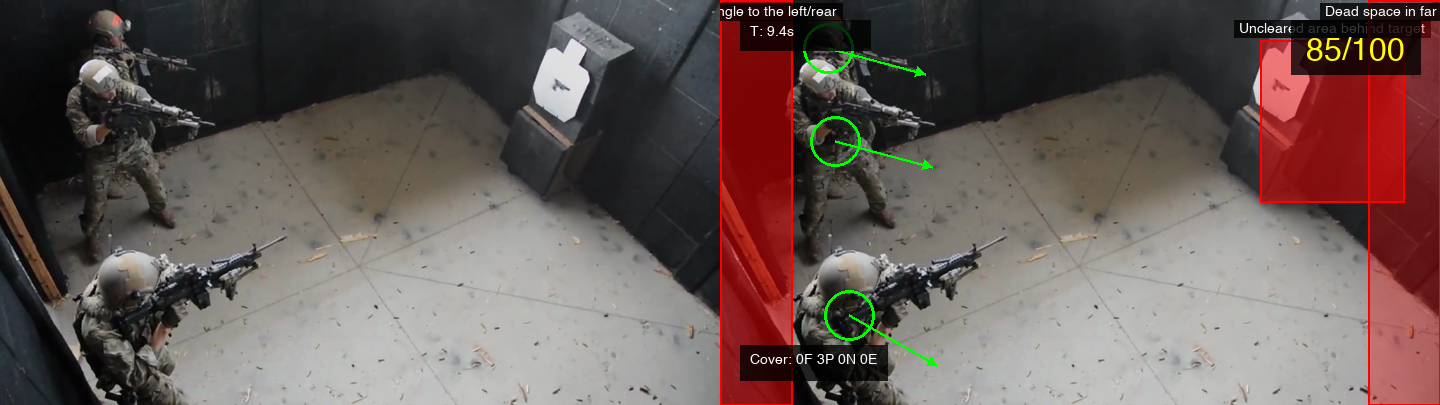

   ⬅️ Original                    Annotated ➡️


📸 Frame 2 - 18.9s | Score: 91/100
------------------------------------------------------------


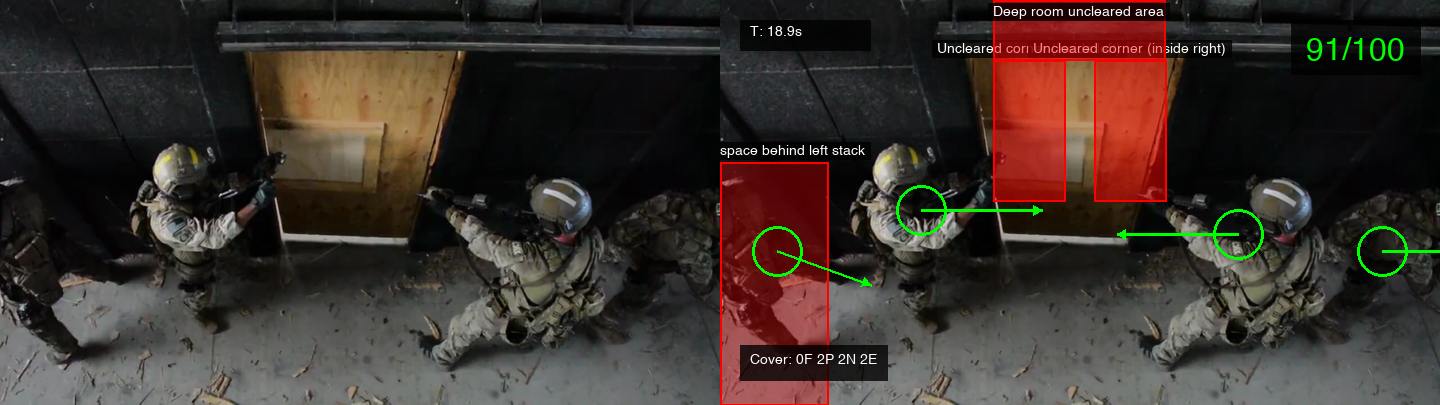

   ⬅️ Original                    Annotated ➡️


📸 Frame 3 - 28.3s | Score: 62/100
------------------------------------------------------------


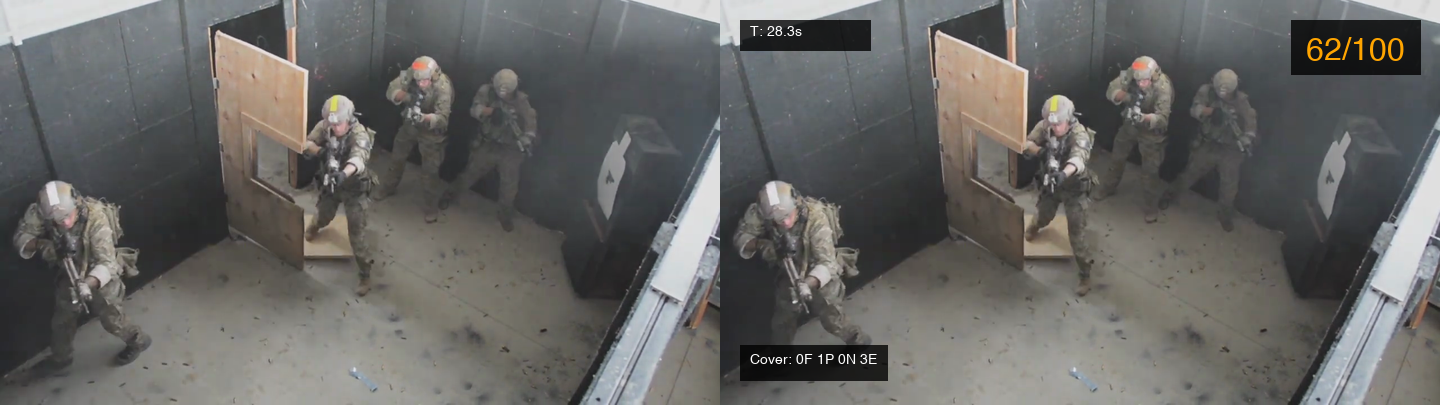

   ⬅️ Original                    Annotated ➡️

✅ All frames displayed


In [6]:
from PIL import Image as PILImage

print("🖼️  COMPARING ORIGINAL vs ANNOTATED FRAMES")
print("=" * 60)

for result in annotated_results:
    idx = result['index']
    timestamp = result['timestamp']
    original = result['original']
    annotated = result['annotated']
    analysis = result['analysis']
    
    score = analysis.get('score', 0)
    
    print(f"\n📸 Frame {idx + 1} - {timestamp:.1f}s | Score: {score}/100")
    print("-" * 60)
    
    # Create side-by-side comparison
    width = original.width
    height = original.height
    
    comparison = PILImage.new('RGB', (width * 2, height))
    comparison.paste(original, (0, 0))
    comparison.paste(annotated, (width, 0))
    
    # Display
    display(comparison)
    
    print("   ⬅️ Original                    Annotated ➡️")
    print()

print("=" * 60)
print("✅ All frames displayed")
print("=" * 60)

## Cell 7: Stage 2 Summary

Analysis complete - ready for Stage 3 (Performance Summary)

In [7]:
print("🚀 STAGE 2 COMPLETE: FRAME ANALYSIS & ANNOTATION")
print("=" * 60)

# Calculate statistics
total_frames = len(analysis_results)
avg_score = sum(r['analysis'].get('score', 0) for r in analysis_results) / total_frames if total_frames > 0 else 0
total_errors = sum(len(r['analysis'].get('tactical_errors', [])) for r in analysis_results)
total_strengths = sum(len(r['analysis'].get('tactical_strengths', [])) for r in analysis_results)

# Format timestamps for display
timestamps_str = [f"{r['timestamp']:.1f}s" for r in analysis_results]

print(f"\n📋 Summary:")
print(f"  🎥 Video: {video_metadata['filename']}")
print(f"  ⏱️  Duration: {video_metadata['duration']:.1f} seconds")
print(f"  📊 Frames analyzed: {total_frames}")
print(f"  📍 Positions: {[f'{int(p*100)}%' for p in config.FRAME_EXTRACTION_POSITIONS]}")
print(f"  ⏱️  Timestamps: {timestamps_str}")

print(f"\n🎯 Analysis Results:")
print(f"  Average Score: {avg_score:.1f}/100")
print(f"  Total Tactical Errors: {total_errors}")
print(f"  Total Tactical Strengths: {total_strengths}")

print(f"\n💾 Outputs:")
print(f"  JSON files: {config.ANALYSIS_JSON_DIR / video_name}")
print(f"  Annotated frames: {config.ANNOTATED_FRAMES_DIR / video_name}")

print(f"\n🎯 Data Available for Stage 3:")
print(f"  • analysis_results: List[Dict] ({len(analysis_results)} items)")
print(f"  • annotated_results: List[Dict] ({len(annotated_results)} items)")
print(f"  • video_metadata: Dict with video information")
print(f"  • scenario_context: String description")

print(f"\n📂 Next Steps:")
print(f"  1. Open Stage 3 notebook: 03_performance_summary_demo.ipynb")
print(f"  2. Pass analysis_results to summary generator")
print(f"  3. Generate overall performance report")

print(f"\n" + "=" * 60)
print("✨ Ready for Stage 3: Performance Summary!")

🚀 STAGE 2 COMPLETE: FRAME ANALYSIS & ANNOTATION

📋 Summary:
  🎥 Video: urban_warfare_training.mp4
  ⏱️  Duration: 37.7 seconds
  📊 Frames analyzed: 3
  📍 Positions: ['25%', '50%', '75%']
  ⏱️  Timestamps: ['9.4s', '18.9s', '28.3s']

🎯 Analysis Results:
  Average Score: 79.3/100
  Total Tactical Errors: 6
  Total Tactical Strengths: 9

💾 Outputs:
  JSON files: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst/outputs/analysis_json/urban_warfare_training
  Annotated frames: /Users/samuel.tan/Desktop/Other Projects/2025 Q4/Army AI Transformation/Urban Warfare Analyst/outputs/annotated_frames/urban_warfare_training

🎯 Data Available for Stage 3:
  • analysis_results: List[Dict] (3 items)
  • annotated_results: List[Dict] (3 items)
  • video_metadata: Dict with video information
  • scenario_context: String description

📂 Next Steps:
  1. Open Stage 3 notebook: 03_performance_summary_demo.ipynb
  2. Pass analysis_results to summary generator
  3. 

---

## Implementation Notes

### Stage 2 Features:
- **AI Analysis**: Gemini 2.5 Flash for fast tactical analysis
- **JSON Output**: Structured analysis saved separately
- **Annotated Frames**: Visual overlays with soldier positions, threats, scores
- **Separate Folders**: 
  - `outputs/analysis_json/<video_name>/` - Analysis JSON files
  - `outputs/annotated_frames/<video_name>/` - Annotated images

### Annotation Features:
- **Soldier Positions**: Color-coded circles based on cover status
  - Green: Full cover
  - Yellow: Partial cover
  - Orange: No cover
  - Red: Exposed
- **Threat Markers**: Triangles with color-coded threat levels
- **Score Overlay**: Top-right corner with color-coded score
- **Timestamp**: Top-left corner

### Performance:
- Analysis: ~20-30 seconds per frame
- Annotation: ~2-5 seconds per frame
- Total Stage 2: ~90 seconds for 3 frames

### Success Criteria: ✅
- [x] Load frames from Stage 1
- [x] Send to Gemini 2.5 Flash for analysis
- [x] Parse structured JSON responses
- [x] Save JSON to separate folder
- [x] Generate annotated frames with overlays
- [x] Save annotated images to separate folder
- [x] Display side-by-side comparisons
- [x] Prepare data for Stage 3